# STIRAP in a 3-level system
STIRAP (STImulated Raman Adiabatic Passage, see e.g. [Shore1998](https://journals.aps.org/rmp/pdf/10.1103/RevModPhys.70.1003)) is a method for adiabatically transferring the population of a quantum system from one state to another by using two drive fields coupled to an intermediate state without actually ever populating the intermediate state. The benefits over e.g. two Rabi pulses, are that since STIRAP is an adiabatic process, it is relatively easy (I've been told) to make it highly efficient. The other key benefit is that the intermediate state can be an unstable state, yet there is no population loss since it is never populated.

This notebook sets up a 3-level system and relevant couplings using the `toy_models` package and then time evolves the system using `QuTiP` to simulate STIRAP. I'll be following the definitions of Shore1998 as best as I can. The level diagram from the paper is shown below.

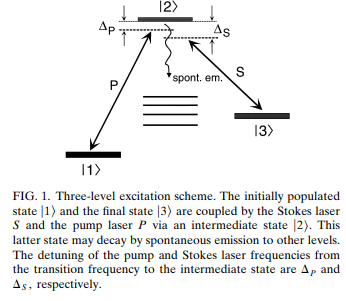
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import Decay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Set up states and basis
We start by defining the three states of the system: we'll have two ground states (i.e. states that don't decay) $|1\rangle$ and $|3\rangle$, and one excited state $|2\rangle$, which we will later set to have a decay path out of the system:

In [2]:
# Define states
s1 = BasisState(qn=ToyQuantumNumbers(label="1"))
s2 = BasisState(qn=ToyQuantumNumbers(label="2"))
s3 = BasisState(qn=ToyQuantumNumbers(label="3"))
s4 = BasisState(qn=ToyQuantumNumbers(label="4")) # A target state for decays from |2>

# Define basis
basis = Basis((s1, s2, s3, s4))
basis.print_basis()

|0> = |1>
|1> = |2>
|2> = |3>
|3> = |4>


## Define energies, couplings and decays
I'm going to define the system in the rotating frame as given in [Shore1998](https://journals.aps.org/rmp/pdf/10.1103/RevModPhys.70.1003) so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$.

The Hamiltonian I'm trying to produce is shown below (with $\hbar = 1$): 

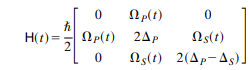

### Energies

In [3]:
Δp = Symbol('Delta_p') # Detuning for pump beam
Δs = Symbol('Delta_s') # Detuning for Stokes beam
E1 = ToyEnergy(s1, s1, 0)
E2 = ToyEnergy(s2, s2, Δp)

# The energy for state |3> needs to be defined in two parts since it contains two sympy.Symbols
E3p = ToyEnergy(s3, s3, Δp)
E3s = ToyEnergy(s3, s3, -Δs)

### Couplings

In [8]:
Ωp = Symbol('Omega_p') # Drive field Rabi rate for pump beam
Ωs = Symbol('Omega_s') # Drive field Rabi rate for Stokes beam

coupling_p = ToyCoupling(s1,s2,Ωp/2, time_dep = "exp(-(t-t_p)**2/(2*sigma_p**2))", time_args= {"t_p":-1, "sigma_p":1})
coupling_s = ToyCoupling(s2,s3,Ωs/2, time_dep = "exp(-(t-t_s)**2/(2*sigma_s**2))", time_args= {"t_s":1, "sigma_s":1})

### Hamiltonian

In [9]:
# Generate the Hamiltonian based on the couplings and the energies
H = Hamiltonian(basis, couplings=(E1, E2, E3p, E3s, coupling_p, coupling_s))
display(H)

H =
[
[                   0,            Omega_p/2,                 0, 0],
[conjugate(Omega_p)/2,              Delta_p,         Omega_s/2, 0],
[                   0, conjugate(Omega_s)/2, Delta_p - Delta_s, 0],
[                   0,                    0,                 0, 0]]

in basis Basis: name = None

### Decays
Defining a decay from $|2\rangle$ to $|4\rangle$:

In [10]:
decay = Decay(s2, ground = s4, gamma = Symbol("Gamma"))
decay.generate_decay_matrix(basis)
decay.matrix_sym

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, Gamma**0.5, 0, 0]], dtype=object)

## Time-evolution using `QuTiP`

In [11]:
print("Keys for setting arguments:")
print(H.qobj.args.keys())

Keys for setting arguments:
dict_keys(['Delta_p', 'Delta_s', 't_p', 'sigma_p', 'Omega_p', 't_s', 'sigma_s', 'Omega_s'])


In [84]:
# Generate a Qobj representing the initial state
psi0 = (1*s1).qobj(basis)

# Make operators for getting the probability of being in each state
P_1_op = qutip.Qobj((1*s1).density_matrix(basis), type = "oper")
P_2_op = qutip.Qobj((1*s2).density_matrix(basis), type = "oper")
P_3_op = qutip.Qobj((1*s3).density_matrix(basis), type = "oper")
P_4_op = qutip.Qobj((1*s4).density_matrix(basis), type = "oper")


# Set the parameters for the system
Omega = 1
t0 = 0.4
sigma = 2

H.qobj.args["Delta_p"] = 0
H.qobj.args["Omega_p"] = Omega
H.qobj.args["sigma_p"] = sigma
H.qobj.args["t_p"] = t0

H.qobj.args["Delta_s"] = 0
H.qobj.args["Omega_s"] = Omega
H.qobj.args["sigma_s"] = sigma
H.qobj.args["t_s"] = -t0


times = np.linspace(-20,20,1001) # Times at which result is requested

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(H.qobj, psi0, times, c_ops = decay.qobj(0.01), e_ops = [P_1_op, P_2_op, P_3_op, P_4_op],
                      progress_bar=pb, options = options)

 Total run time:   0.69s*] Elapsed 0.69s / Remaining 00:00:00:00[*********59%**         ] Elapsed 0.43s / Remaining 00:00:00:00[*********62%**         ] Elapsed 0.45s / Remaining 00:00:00:00


Text(0, 0.5, 'Population in each state')

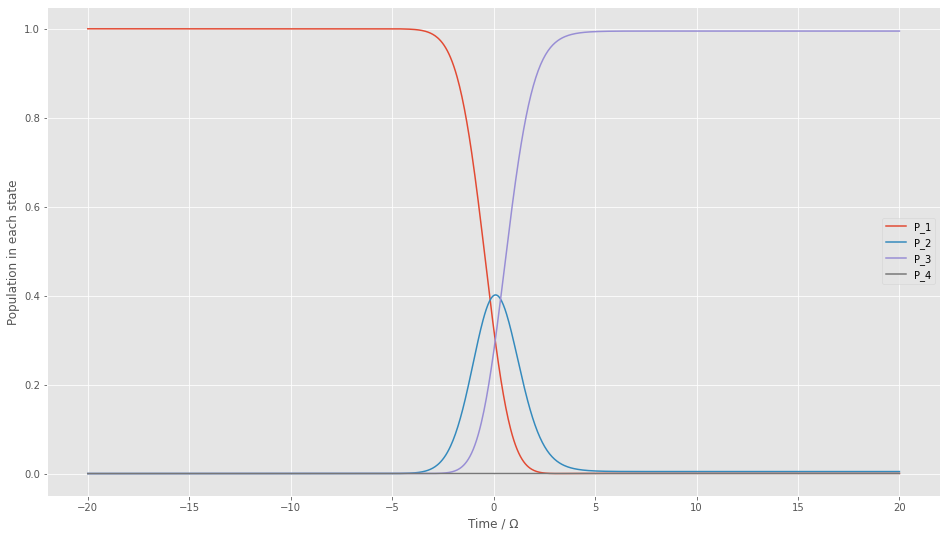

In [85]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_1")
ax.plot(times, result.expect[1], label = "P_2")
ax.plot(times, result.expect[2], label = "P_3")
ax.plot(times, result.expect[3], label = "P_4")
ax.legend()
ax.set_xlabel("Time / Ω")
ax.set_ylabel("Population in each state")